In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
#import helper_functions as helper

In [ ]:
'''08/21/2025
    - reformatted the script for better usability 
    - successfully tested and validated electrode to channel mapping
    - tested reading in a binary file (decided it wasnt the best way to go due to non MEA specific recording
    ongoing tasks for today to tick off
    - get the channels to plot traces then change from channels to electrodes 
    - get the electrode x y coordinates, and distance from 0,0 
    - get electrode stats '''

In [2]:
import os
#give path to the IPN Analysis
path = '/home/shruti/MEA_Analysis/IPNAnalysis'
os.chdir(path)


In [19]:
#Reading the file, BP filtering
local_path= '/home/shruti/Downloads/KCNT1_MEAslices/250606_Old/M07896/Network/000003/data.raw.h5' #network data from chip 16848
recording1 = se.read_maxwell(local_path,stream_id = 'well004') # starts with well000 so make sure to use the right one
freq_min = 300
freq_max = 4500


#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=freq_min, freq_max=freq_max)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 500*fs,end_frame=600*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")



Sampling frequency: 10000.0
Number of channels: 899
Number of segments: 1
total_recording: 1200.04 s
chunk duration: 100.0 s


In [20]:
recording_chunk.get_memory_size()


1798000000

In [21]:
#** TESTING THE ELECTRODES MAPPING **#
# Initialize the electrodes list
electrodes = []
channel_location_dict = {}

# Get channel IDs and locations
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()

# Populate the electrodes list
for channel, loc in zip(channel_ids, locations):
    # Calculate electrode ID based on location
    electrode_id = 220 * int(loc[1] / 17.5) + int(loc[0] / 17.5)
    electrodes.append(electrode_id)
    channel_location_dict[channel] = electrode_id  # Map channel to electrode

# Validate the electrodes list
if len(electrodes) != len(channel_ids):
    print(f"Warning: Mismatch between number of channels ({len(channel_ids)}) and electrodes ({len(electrodes)}).")
else:
    print(f"Successfully mapped {len(electrodes)} electrodes.")

Successfully mapped 899 electrodes.


In [22]:
electrodes = []
channel_location_dict = {}
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()
for channel,locations in zip(channel_ids, locations):
    electrodes.append(220* int(locations[1]/17.5)+int(locations[0]/17.5))

print(electrodes)
print(len(electrodes))

[12910, 16217, 10258, 20402, 13543, 16213, 13981, 9847, 15777, 11380, 15086, 14675, 16203, 11356, 5411, 15117, 12886, 14651, 15739, 17320, 13565, 14010, 11793, 15113, 13580, 14646, 17760, 16179, 11822, 12458, 16196, 13983, 10273, 14005, 12480, 15110, 11353, 12913, 16643, 16225, 14670, 12917, 10253, 8728, 16619, 16638, 9811, 12473, 15741, 21505, 14663, 11786, 18415, 12888, 14022, 11358, 12927, 12446, 12891, 18417, 14020, 13556, 7207, 13553, 18853, 15763, 10285, 7171, 18857, 10270, 13560, 12898, 15787, 10903, 16667, 15765, 19510, 11820, 17308, 17315, 13563, 11796, 8051, 17757, 14660, 14680, 14648, 18398, 11370, 12453, 17753, 10940, 9801, 14008, 13539, 9182, 15098, 15105, 7633, 13551, 18410, 12456, 15122, 13993, 15758, 14003, 13568, 13988, 15125, 7613, 6088, 13548, 18860, 9833, 15751, 14665, 11827, 14017, 16200, 8085, 16621, 22162, 12477, 12439, 16660, 8740, 17726, 20385, 11368, 17728, 16650, 6090, 18393, 16208, 9825, 15100, 12485, 9168, 18391, 19943, 10908, 16623, 16626, 10263, 14639, 10

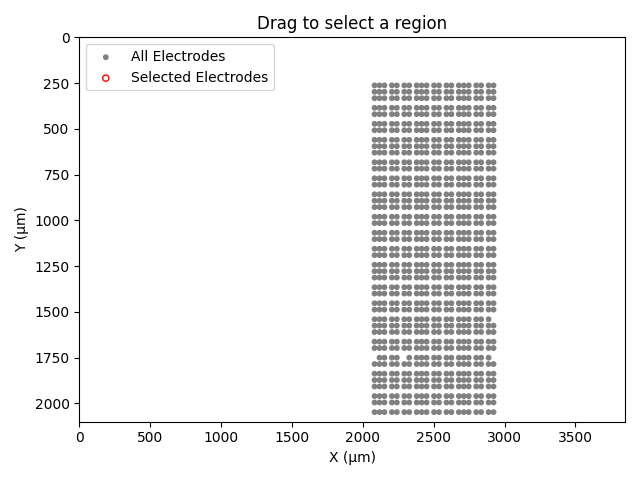

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

# Enable interactive matplotlib
%matplotlib widget

# Ensure required variables are defined
# Replace these with your actual data
locs = recording_chunk.get_channel_locations()  # 2D locations of electrodes
channel_ids = recording_chunk.get_channel_ids()  # Channel IDs
electrodes = np.array(electrodes)  # List of electrode IDs

# Widgets to enter electrode IDs to highlight
highlight_input = widgets.Text(
    description='Highlight:',
    placeholder='e.g. 10, 15, 23',
    layout=widgets.Layout(width='50%')
)

highlight_button = widgets.Button(
    description='Highlight Electrodes',
    button_style='info'
)

# Setup figure
fig, ax = plt.subplots()

# Initial colors: all gray
c = np.array(['gray'] * len(electrodes))

def update_highlight_colors(electrodes_to_highlight):
    global c
    c = np.array(['gray'] * len(electrodes))
    highlight_mask = np.isin(electrodes, electrodes_to_highlight)
    c[highlight_mask] = 'blue'
    sc.set_color(c)
    fig.canvas.draw_idle()

# Scatter plot of electrode locations
sc = ax.scatter(locs[:, 0], locs[:, 1], c=c, label='All Electrodes', s=10)
ax.set_title("Drag to select a region")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")

# Invert the y-axis to match typical electrode layouts
ax.invert_yaxis()

# Scatter plot for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Electrodes')
selected_electrodes = []

# Create an output widget for displaying messages
output = widgets.Output()

# Function to map electrodes to channel numbers
def map_electrodes_to_channels(electrode_list):
    channel_numbers = []
    for electrode in electrode_list:
        if electrode in electrodes:
            channel_index = electrodes.tolist().index(electrode)  # Find the index of the electrode
            channel_numbers.append(channel_ids[channel_index])  # Map to channel number
        else:
            print(f"Electrode {electrode} not found.")
    return list(map(int, channel_numbers))

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_electrodes
    if eclick.xdata is None or erelease.xdata is None:  # Ignore clicks outside the plot
        return

    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata

    # Mask to find electrodes within the selected region
    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = electrodes[mask]

    # Check if Ctrl key is pressed (use event modifiers)
    if eclick.key == 'control':  # Append to existing selection
        selected_electrodes = np.unique(np.concatenate((selected_electrodes, new_selection)))
    else:  # Overwrite selection
        selected_electrodes = new_selection

    # Update the scatter plot for selected electrodes
    selected_plot.set_offsets(locs[np.isin(electrodes, selected_electrodes)])
    fig.canvas.draw_idle()

    # Display the selection details in the output widget
    with output:
        output.clear_output()  # Clear previous messages
        print(f"🔴 Selected {len(selected_electrodes)} electrodes")
        print(selected_electrodes)
        mapped_channels = map_electrodes_to_channels(selected_electrodes)
        print("Mapped Channels:", mapped_channels)
# Create RectangleSelector
selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]  # Left mouse button
)

# Create save button
save_button = widgets.Button(
    description="💾 Save Selected Electrodes",
    button_style='success',
    tooltip='Save selected electrode IDs to file'
)

def on_highlight_button_click(b):
    with output:
        output.clear_output()
        try:
            input_text = highlight_input.value.strip()
            if input_text == "":
                print("No electrodes entered.")
                return
            electrodes_to_highlight = np.array([int(x.strip()) for x in input_text.split(',')])
            update_highlight_colors(electrodes_to_highlight)
            print(f"🔵 Highlighted electrodes: {electrodes_to_highlight}")
        except Exception as e:
            print(f"Error parsing input: {e}")

highlight_button.on_click(on_highlight_button_click)

# Define callback to save to file
def save_selected_electrodes_to_file(b):
    if len(selected_electrodes) == 0:
        with output:
            output.clear_output()
            print("No electrodes selected to save.")
        return

    save_path = "selected_electrodes.txt"
    with open(save_path, "w") as f:
        for el in selected_electrodes:
            f.write(f"{el}\n")

    with output:
        output.clear_output()
        print(f"Saved {len(selected_electrodes)} electrode IDs to {os.path.abspath(save_path)}")

# Attach callback and show button
save_button.on_click(save_selected_electrodes_to_file)

# Display all controls
display(widgets.VBox([
    widgets.HBox([highlight_input, highlight_button]),
    save_button,
    output
]))
plt.xlim([0,3850])
plt.ylim(2100,0)

plt.legend()
plt.tight_layout()
plt.show()

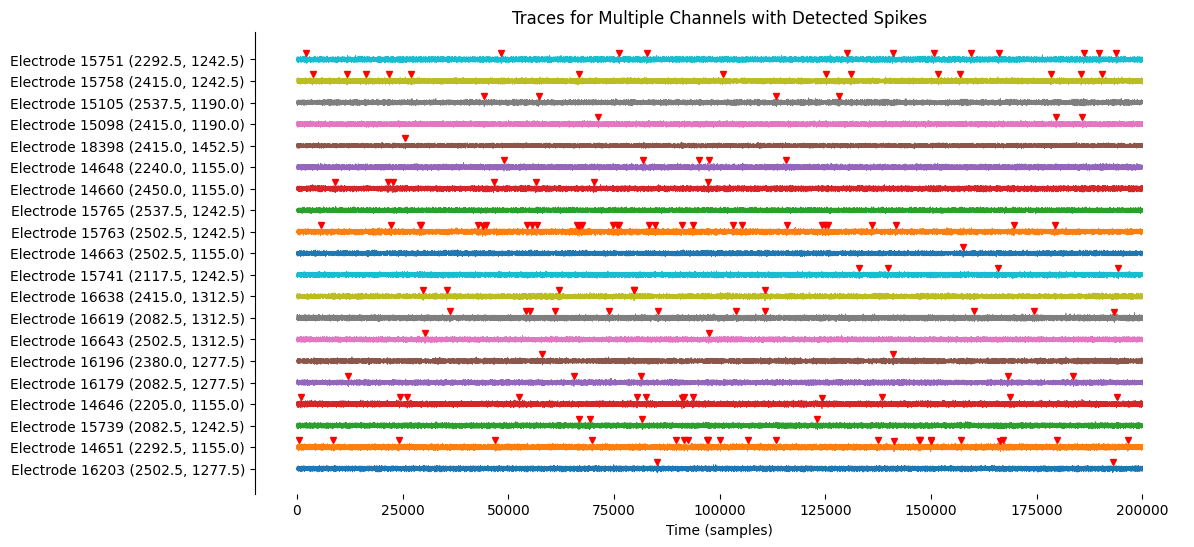

In [31]:
import os

import numpy as np
import matplotlib.pyplot as plt

plt.close('all')  # Close all existing figures to prevent multiple plots

# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    """
    Detect peaks in a signal based on standard deviation thresholding.

    Parameters:
    - trace: 1D numpy array, the signal to analyze
    - peak_sign: str, "pos" for positive peaks, "neg" for negative peaks
    - std_multiplier: float, the threshold multiplier for peak detection

    Returns:
    - peaks: numpy array, indices of detected peaks
    - threshold: float, the threshold value used for detection
    """
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")

    return peaks, threshold
%matplotlib inline
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot = [ 12, 17, 18, 26, 28, 31, 40, 46, 47, 50, 53, 68, 78, 88, 90, 91, 102, 103, 111, 122]
fs = recording_chunk.get_sampling_frequency()
start_time = 40 # Start time in seconds
end_time = 60 # End time in seconds
# Get traces for the specified range
traces = recording_chunk.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)

# Define the channels you want to plot
 # Replace with the desired channel indices
#channels_to_plot = range(traces.shape[1])  # Example channel indices
# Parameters for spike detection
peak_sign = "neg"  # Detect negative peaks
std_multiplier = 4 # Threshold: 1 standard deviation from the mean

# Adjust figure height dynamically based on the number of channels
plt.figure(figsize=(12, len(channels_to_plot) * 0.3))  # Increase height for better spacing

# Extract channel IDs and 2D location coordinates
channel_ids = np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()  # Define locs here
# Ensure channels_to_plot only contains valid indices within the bounds of the traces array
channels_to_plot_indices = [np.where(channel_ids == ch)[0][0] for ch in channels_to_plot if ch in channel_ids]

# Loop through the channels and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling

spike_times_channel = {} # Store spike times for each channel
for i, channel_idx in enumerate(channels_to_plot_indices):
    # Get the trace for the current channel
    trace = traces[:, channel_idx]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

    
    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_channel[channel] = peaks_sample_inds  # Store spike times for the channel

    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Electrode {electrodes[channel_idx]}',  # Use the actual channel ID for labeling
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Channel {electrodes[channel_idx]}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    
    # Retrieve the x, y coordinates for the channel
    x, y = locs[channel_idx]  # Use the index to get the location
    yticks_labels.append(f'Electrode {electrodes[channel_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')

# Add y-axis ticks with channel names and coordinates
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_multiple_channels_with_spikes.pdf'  # Replace with your desired path
plt.show() 
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
plt.close()  # Close the plot to free memory

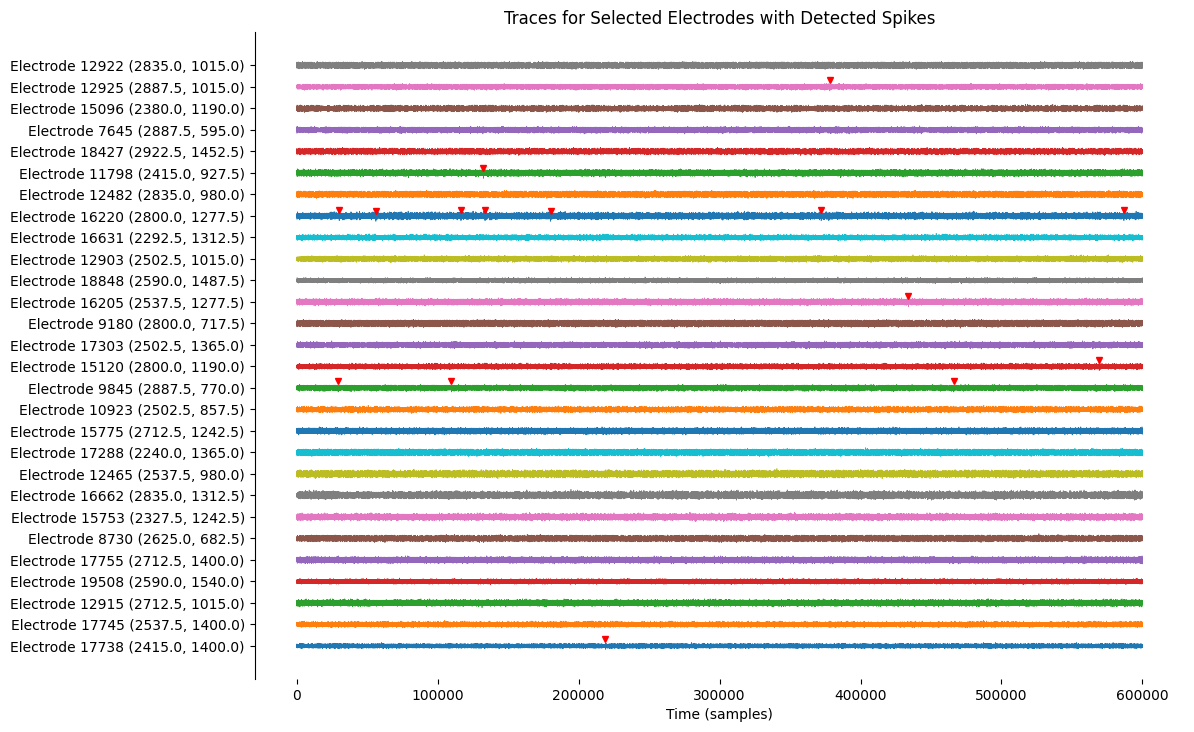

In [27]:
import os

import numpy as np
import matplotlib.pyplot as plt


# Define the detect_peaks_stddev function
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    """
    Detect peaks in a signal based on standard deviation thresholding.

    Parameters:
    - trace: 1D numpy array, the signal to analyze
    - peak_sign: str, "pos" for positive peaks, "neg" for negative peaks
    - std_multiplier: float, the threshold multiplier for peak detection

    Returns:
    - peaks: numpy array, indices of detected peaks
    - threshold: float, the threshold value used for detection
    """
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std

    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")

    return peaks, threshold

%matplotlib inline
plt.close('all')  # Close all existing figures to prevent multiple plots

# Replace this list with the provided electrode numbers
electrodes_to_plot = [
   17738, 17745, 12915, 19508, 17755, 8730, 15753, 16662, 12465, 17288, 15775, 10923, 9845, 15120, 17303, 9180, 16205, 18848, 12903, 16631, 16220, 12482, 11798, 18427, 7645, 15096, 12925, 12922
]

# Sampling frequency
fs = recording_chunk.get_sampling_frequency()

# Define the time range for extracting traces
start_time = 40  # Start time in seconds
end_time = 100    # End time in seconds

# Extract traces from the recording chunk
traces = recording_chunk.get_traces(
    start_frame=int(start_time * fs), 
    end_frame=int(end_time * fs), 
    segment_index=0, 
    return_scaled=True
)

peaks_sign = "neg"  # Peak sign for detection

std_multiplier = 5 # Standard deviation multiplier for peak detection
traces = recording_chunk.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)


# Map electrodes to their corresponding channel indices
electrodes_to_plot_indices = [np.where(np.array(electrodes) == el)[0][0] for el in electrodes_to_plot if el in electrodes]

# Adjust figure height dynamically based on the number of electrodes
plt.figure(figsize=(12, len(electrodes_to_plot_indices) * 0.3))  # Increase height for better spacing

# Loop through the electrodes and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store electrode names for labeling

spike_times_electrode = {}  # Store spike times for each electrode
for i, electrode_idx in enumerate(electrodes_to_plot_indices):
    # Get the trace for the current electrode
    trace = traces[:, electrode_idx]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign="neg", std_multiplier= std_multiplier)

    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_times_electrode[electrodes[electrode_idx]] = peaks_sample_inds  # Store spike times for the electrode

    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Electrode {electrodes[electrode_idx]}',  # Use the actual electrode ID for labeling
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Electrode {electrodes[electrode_idx]}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    
    # Retrieve the x, y coordinates for the electrode
    x, y = locations[electrode_idx]  # Use the index to get the location
    yticks_labels.append(f'Electrode {electrodes[electrode_idx]} ({x:.1f}, {y:.1f})')  # Format with coordinates

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Selected Electrodes with Detected Spikes')

# Add y-axis ticks with electrode names and coordinates
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_selected_electrodes_with_spikes.pdf'  # Replace with your desired path
plt.show()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
plt.close()  # Close the plot to free memory

Electrode 3419: 2098.98 μm
Electrode 3859: 2103.64 μm
Electrode 4299: 2108.88 μm
Electrode 4959: 2117.79 μm
Electrode 5399: 2124.43 μm
Electrode 3421: 2133.71 μm
Electrode 6059: 2135.43 μm
Electrode 3861: 2138.30 μm
Electrode 6499: 2143.45 μm
Electrode 4301: 2143.45 μm
Electrode 4961: 2152.22 μm
Electrode 7159: 2156.48 μm
Electrode 5401: 2158.75 μm
Electrode 7599: 2165.83 μm
Electrode 3423: 2168.45 μm
Electrode 6061: 2169.58 μm
Electrode 3863: 2172.96 μm
Electrode 8039: 2175.71 μm
Electrode 6501: 2177.47 μm
Electrode 4303: 2178.03 μm
Electrode 4963: 2186.66 μm
Electrode 7161: 2190.30 μm
Electrode 8699: 2191.49 μm
Electrode 5403: 2193.09 μm
Electrode 7601: 2199.51 μm
Electrode 9139: 2202.64 μm
Electrode 6063: 2203.75 μm
Electrode 8041: 2209.23 μm
Electrode 6503: 2211.52 μm
Electrode 9799: 2220.29 μm
Electrode 3426: 2220.57 μm
Electrode 7163: 2224.15 μm
Electrode 8701: 2224.77 μm
Electrode 3866: 2224.98 μm
Electrode 4306: 2229.93 μm
Electrode 10239: 2232.67 μm
Electrode 7603: 2233.22 μm


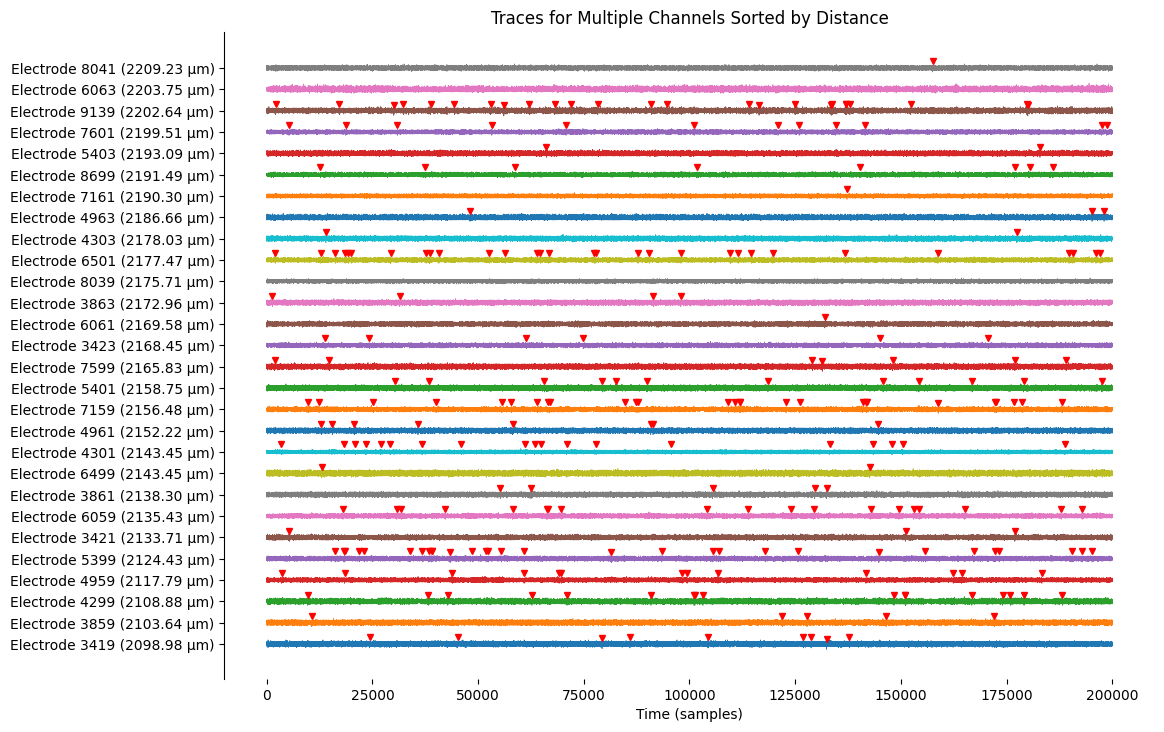

In [32]:
# Sort electrodes based on distance from reference point (0, 0)

import numpy as np
import matplotlib.pyplot as plt

# Define the reference point
reference_point = (0, 0)

# Retrieve the 2D locations of the electrodes
locs = recording_chunk.get_channel_locations()

# Calculate distances for each electrode
distances = np.sqrt((locs[:, 0] - reference_point[0])**2 + (locs[:, 1] - reference_point[1])**2)

# Sort electrodes by distance (ascending order)
sorted_indices = np.argsort(distances)
sorted_electrodes = [electrodes[idx] for idx in sorted_indices]
sorted_distances = distances[sorted_indices]


for electrode, distance in zip(sorted_electrodes, sorted_distances):
    print(f"Electrode {electrode}: {distance:.2f} μm")

# Update the order of electrodes to plot based on sorted electrodes
electrodes_to_plot_sorted = [electrode for electrode in sorted_electrodes if electrode in electrodes_to_plot]


# Validate that electrodes_to_plot_sorted is not empty
if not electrodes_to_plot_sorted:
    raise ValueError("The `electrodes_to_plot_sorted` list is empty. Ensure `electrodes_to_plot` and `electrodes` are correctly defined.")

# Plot the sorted electrodes
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store electrode names for labeling

plt.figure(figsize=(12, len(electrodes_to_plot_sorted) * 0.3))  # Adjust figure height dynamically

spike_marker_offset = 100  # Define spike marker offset

for i, electrode in enumerate(electrodes_to_plot_sorted):
    electrode_idx_array = np.where(np.array(electrodes) == electrode)[0]
    if electrode_idx_array.size == 0:
        print(f"Warning: Electrode {electrode} not found in electrodes.")
        continue  # Skip this electrode if it is not found
    trace = traces[:, electrode_idx_array[0]]
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)

    # Check if spikes are detected
    if len(peaks_sample_inds) == 0:
        print(f"Warning: No spikes detected for electrode {electrode}.")

    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )

    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Electrode {electrodes[electrode_idx]}'
    )
    yticks_positions.append(i * 200)
    yticks_labels.append(f'Electrode {sorted_electrodes[i]} ({sorted_distances[i]:.2f} μm)')

     

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels Sorted by Distance')
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './sorted_traces_by_distance.pdf'
plt.show()
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)
plt.close()



In [33]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
%matplotlib widget

# Visualize the traces interactively
print("Visualizing traces interactively...")
sw.plot_traces(recording_chunk, mode='line',show_channel_ids=[661, 720, 748, 752, 909, 976], backend='ipywidgets')  # Updated function name

# Create a text box for user input
electrode_input = widgets.Text(
    description="Electrode:",
    placeholder="Enter electrode number",
)

# Create an output widget to display the result
output = widgets.Output()

# Define a function to handle the input and display the corresponding channel indices
def find_channel_indices(change):
    with output:
        output.clear_output()  # Clear previous output
        try:
            # Get the input value and split it into a list of electrode numbers
            electrode_numbers = [int(e.strip()) for e in change["new"].split(",")]
            channel_indices = []
            for electrode_number in electrode_numbers:
                if electrode_number in electrodes:
                    channel_index = electrodes.index(electrode_number)  # Find the index
                    channel_indices.append(channel_index)
                else:
                    print(f"Electrode {electrode_number} not found.")
            if channel_indices:
                print(f"Electrode numbers {electrode_numbers} correspond to Channel Indices {channel_indices}")
        except ValueError:
            print("Please enter valid integers separated by commas.")

# Attach the function to the text box
electrode_input.observe(find_channel_indices, names="value")

# Display the widgets
display(widgets.VBox([electrode_input, output]))



Visualizing traces interactively...


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

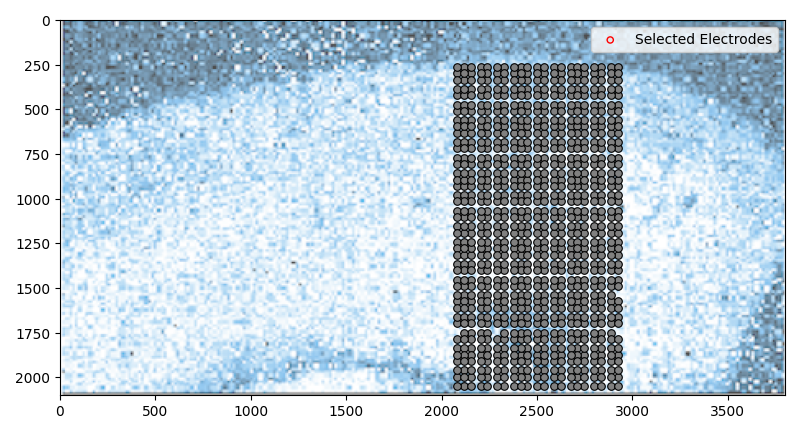

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

from matplotlib.image import imread

# Enable interactive matplotlib
%matplotlib widget

# Load the background image
img_path = "/home/shruti/MEA_Analysis/IPNAnalysis/plotting_MEAslices/run6_well5_M07037.png"
img = imread(img_path)

# Get electrode locations
locs = recording_chunk.get_channel_locations()
channel_ids = recording_chunk.get_channel_ids()
electrodes = np.array(electrodes)

# Determine extent for the image (fit to locs)
# Define full plot extent to cover entire brain slice (adjust to your known coordinates)
x_min, x_max = 0, 3800
y_min, y_max = 0, 2100


# Calculate aspect ratio of the image
img_height, img_width = img.shape[:2]
aspect_ratio = img_width / img_height

# Set figure size with correct aspect ratio (tune fig_width as desired)
fig_width = 8  # inches
fig_height = fig_width / aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Show image with extent matching electrode locations and invert y for coordinate match
# Show background image spanning entire coordinate range
ax.imshow(img, extent=[x_min, x_max, y_max, y_min], aspect='auto', alpha=0.7)
# After displaying image, plot electrodes
electrode_marker_size = 30  # increase size for visibility
electrode_edge_color = 'black'
# Electrode scatter plot remains unchanged (already in correct coordinates)
sc = ax.scatter(
    locs[:, 0], locs[:, 1],
    c='grey',
    s=30,
    edgecolors='black',
    linewidth=0.8
)

# Set axis limits tightly to image extents to fill whole graph
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_max, y_min)  # y inverted

# Invert y-axis explicitly for MEA layout matching
#ax.invert_yaxis()


# Scatter plot for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Electrodes')
selected_electrodes = []

# Widgets to enter electrode IDs to highlight
highlight_input = widgets.Text(
    description='Highlight:',
    placeholder='e.g. 10, 15, 23',
    layout=widgets.Layout(width='50%')
)
highlight_button = widgets.Button(
    description='Highlight Electrodes',
    button_style='info'
)
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_electrodes
    if eclick.xdata is None or erelease.xdata is None:
        return
    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata
    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = electrodes[mask]
    if eclick.key == 'control':
        selected_electrodes = np.unique(np.concatenate((selected_electrodes, new_selection)))
    else:
        selected_electrodes = new_selection
    selected_plot.set_offsets(locs[np.isin(electrodes, selected_electrodes)])
    fig.canvas.draw_idle()
    with output:
        output.clear_output()
        print(f"🔴 Selected {len(selected_electrodes)} electrodes")
        print(selected_electrodes)

selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]
)

save_button = widgets.Button(
    description="💾 Save Selected Electrodes",
    button_style='success',
    tooltip='Save selected electrode IDs to file'
)

def on_highlight_button_click(b):
    with output:
        output.clear_output()
        try:
            input_text = highlight_input.value.strip()
            if input_text == "":
                print("No electrodes entered.")
                return
            electrodes_to_highlight = np.array([int(x.strip()) for x in input_text.split(',')])
            update_highlight_colors(electrodes_to_highlight)
            print(f"🔵 Highlighted electrodes: {electrodes_to_highlight}")
        except Exception as e:
            print(f"Error parsing input: {e}")

highlight_button.on_click(on_highlight_button_click)

def save_selected_electrodes_to_file(b):
    if len(selected_electrodes) == 0:
        with output:
            output.clear_output()
            print("No electrodes selected to save.")
        return
    save_path = "selected_electrodes.txt"
    with open(save_path, "w") as f:
        for el in selected_electrodes:
            f.write(f"{el}\n")
    with output:
        output.clear_output()
        print(f"Saved {len(selected_electrodes)} electrode IDs to {os.path.abspath(save_path)}")

save_button.on_click(save_selected_electrodes_to_file)
display(widgets.VBox([
    widgets.HBox([highlight_input, highlight_button]),
    save_button,
    output
]))


plt.legend()
plt.tight_layout()
plt.show()

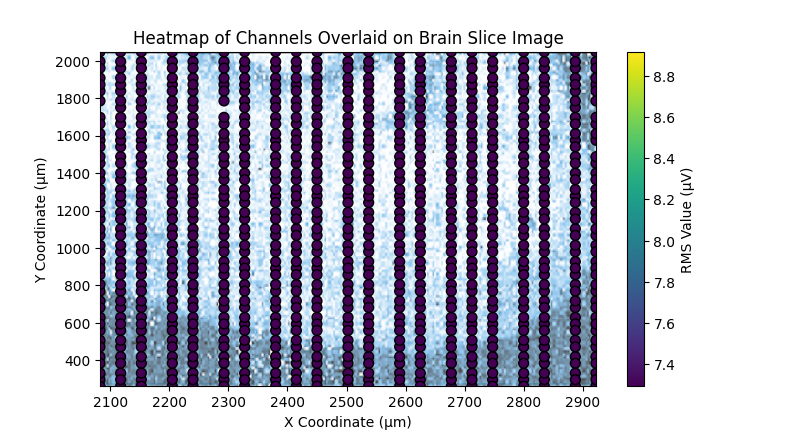

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.image import imread

# Load your background image
img_path = "/home/shruti/MEA_Analysis/IPNAnalysis/plotting_MEAslices/run6_well5_M07037.png"
img = imread(img_path)

# Extract electrode info
locs = np.array(recording_chunk.get_channel_locations())  # shape (n_channels, 2)
channel_ids = recording_chunk.get_channel_ids()
electrodes_array = np.array(electrodes)

# Calculate RMS or another metric for each electrode
rms_values = []
for ch in channel_ids:
    rms = np.sqrt(np.mean(trace**2))
    rms_values.append(rms)
rms_values = np.array(rms_values)

# Extents for image: fit to electrode locations
x_min, x_max = locs[:, 0].min(), locs[:, 0].max()
y_min, y_max = locs[:, 1].min(), locs[:, 1].max()

# Figure and axis with aspect ratio matching image
img_height, img_width = img.shape[:2]
aspect_ratio = img_width / img_height
fig_width = 8
fig_height = fig_width / aspect_ratio
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Show brain slice image as background
ax.imshow(img, extent=[x_min, x_max, y_max, y_min], aspect='auto', alpha=0.7)

# Scatter overlay with color mapped by RMS
norm = colors.Normalize(vmin=rms_values.min(), vmax=rms_values.max())
cmap = cm.viridis
colors_mapped = cmap(norm(rms_values))

sc = ax.scatter(locs[:, 0], locs[:, 1], c=colors_mapped, s=50, edgecolors='k')

# Colorbar setup
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('RMS Value (μV)')

# Axis labeling and inversion of Y for spatial match
ax.set_xlabel('X Coordinate (μm)')
ax.set_ylabel('Y Coordinate (μm)')
ax.invert_yaxis()
ax.set_title('Heatmap of Channels Overlaid on Brain Slice Image')

plt.show()


In [ ]:
'''BREAK UNTIL GOOD CODE'''

In [9]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

def get_events_for_electrode(recording, electrode_id, multiplier=5):
    """
    Detect peaks above threshold for a given electrode.
    electrode_id: int (e.g. 6113)
    multiplier: threshold in multiples of std (default 5)
    """
    # Build electrode → channel map
    channel_ids = recording.get_channel_ids()
    locations = recording.get_channel_locations()
    
    electrode_map = {}
    for ch, loc in zip(channel_ids, locations):
        elec_id = 220 * int(loc[1] / 17.5) + int(loc[0] / 17.5)
        electrode_map[elec_id] = ch

    # Validate electrode
    if electrode_id not in electrode_map:
        raise ValueError(f"Electrode {electrode_id} not found. Available example IDs: {list(electrode_map.keys())[:10]}")
    
    # Get corresponding channel
    channel_id = electrode_map[electrode_id]
    
    # Extract trace
    fs = recording.get_sampling_frequency()
    trace = recording.get_traces(channel_ids=[channel_id])[:, 0]
    
    # Compute threshold
    std_val = np.std(trace)
    threshold = multiplier * std_val
    
    # Find peaks
    peaks, properties = find_peaks(trace, height=threshold)
    times = peaks / fs
    amps = properties["peak_heights"]
    
    # Pack results
    events_df = pd.DataFrame({
        "electrode": electrode_id,
        "channel": channel_id,
        "sample_index": peaks,
        "time_sec": times,
        "amplitude": amps
    })
    return events_df


In [10]:
locations = recording_chunk.get_channel_locations()
print(locations.shape)
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids.shape)

(899, 2)
(899,)


In [13]:
# Function to map channel numbers to electrode numbers
def map_channels_to_electrodes(channel_list):
    electrode_numbers = []
    for channel in channel_list:
        if channel in channel_ids.astype(int):
            channel_index = np.where(channel_ids.astype(int) == channel)[0][0]  # Find the index of the channel
            electrode_numbers.append(electrodes[channel_index])  # Map to electrode number
        else:
            print(f"Channel {channel} not found.")
    return electrode_numbers

# Example usage
input_channels = [442, 399, 262, 225, 209]  # Replace with your desired channel numbers
mapped_electrodes = map_channels_to_electrodes(input_channels)
print("Mapped Electrodes:", mapped_electrodes)

Mapped Electrodes: [18833, 24116, 17300, 9845, 11808]


In [15]:
# Function to map electrodes to channel numbers
def map_electrodes_to_channels(electrode_list):
    channel_numbers = []
    for electrode in electrode_list:
        if electrode in electrodes:
            channel_index = electrodes.tolist().index(electrode)  # Find the index of the electrode
            channel_numbers.append(channel_ids[channel_index])  # Map to channel number
        else:
            print(f"Electrode {electrode} not found.")
    return channel_numbers

# Example usage
user_electrode_list = [18833, 24116, 17300, 9845, 11808]
mapped_channels = map_electrodes_to_channels(user_electrode_list)
print("Mapped Channels:", mapped_channels)

Mapped Channels: ['442', '399', '262', '225', '209']


In [16]:
import spikeinterface.extractors as se
print(dir(se))
# Plot electrode locations for the recording chunk


['ALFSortingExtractor', 'AlphaOmegaEventExtractor', 'AlphaOmegaRecordingExtractor', 'AxonaRecordingExtractor', 'BaseRecording', 'BaseSorting', 'BinaryFolderRecording', 'BinaryRecordingExtractor', 'BiocamRecordingExtractor', 'BlackrockRecordingExtractor', 'BlackrockSortingExtractor', 'CedRecordingExtractor', 'CellExplorerSortingExtractor', 'CombinatoSortingExtractor', 'CompressedBinaryIblExtractor', 'EDFRecordingExtractor', 'HDSortSortingExtractor', 'HerdingspikesSortingExtractor', 'IblStreamingRecordingExtractor', 'IntanRecordingExtractor', 'KiloSortSortingExtractor', 'KlustaSortingExtractor', 'MCSH5RecordingExtractor', 'MCSRawRecordingExtractor', 'MClustSortingExtractor', 'MEArecRecordingExtractor', 'MEArecSortingExtractor', 'MaxwellEventExtractor', 'MaxwellRecordingExtractor', 'MdaRecordingExtractor', 'MdaSortingExtractor', 'NeuralynxRecordingExtractor', 'NeuralynxSortingExtractor', 'NeuroExplorerRecordingExtractor', 'NeuroScopeRecordingExtractor', 'NeuroScopeSortingExtractor', 'NixR

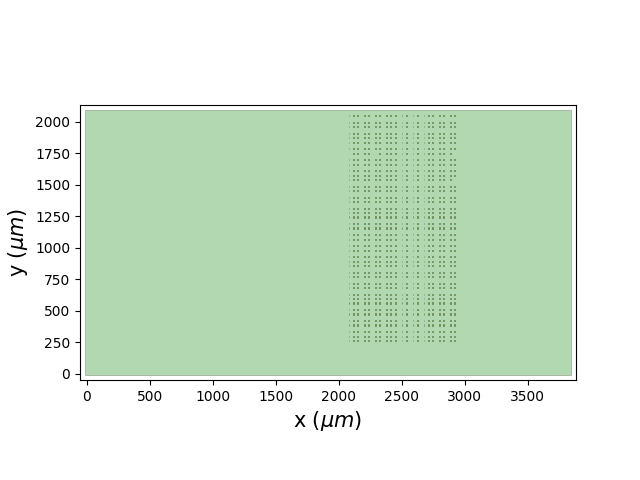

In [34]:
import spikeinterface.widgets as sw

sw.plot_probe_map(recording_chunk)




In [ ]:
sw.plot_unit_waveforms_density_map(sorting, recording)
sw.plot_unit_waveforms(sorting, recording, unit_ids=[0, 1, 2], max_channels=10)